# Semantic Segmentation

- [KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/eval_semantics.php)의 도로 영역(Label 7)을 분리해보자.

- 도로 영역의 segmentation 검출 후 흰색으로 원본 이미지에 오버레이하자.

## 1. 데이터 파이프라인 구성

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.backend import int_shape
from tensorflow.keras.utils import plot_model

[Albumentations](https://github.com/albumentations-team/albumentations/) 라이브러리를 활용해 img augmentation을 적용

![image](https://user-images.githubusercontent.com/86637320/138658377-cc63af1c-8625-48d1-ba81-f3b162c0ee67.png)

Albumentations의 compose는 imgaug의 sometimes처럼 augmentation을 확률적으로 적용할 수 있도록 도와준다.

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

일부 이미지만 augmentation 적용후 확인해보자.

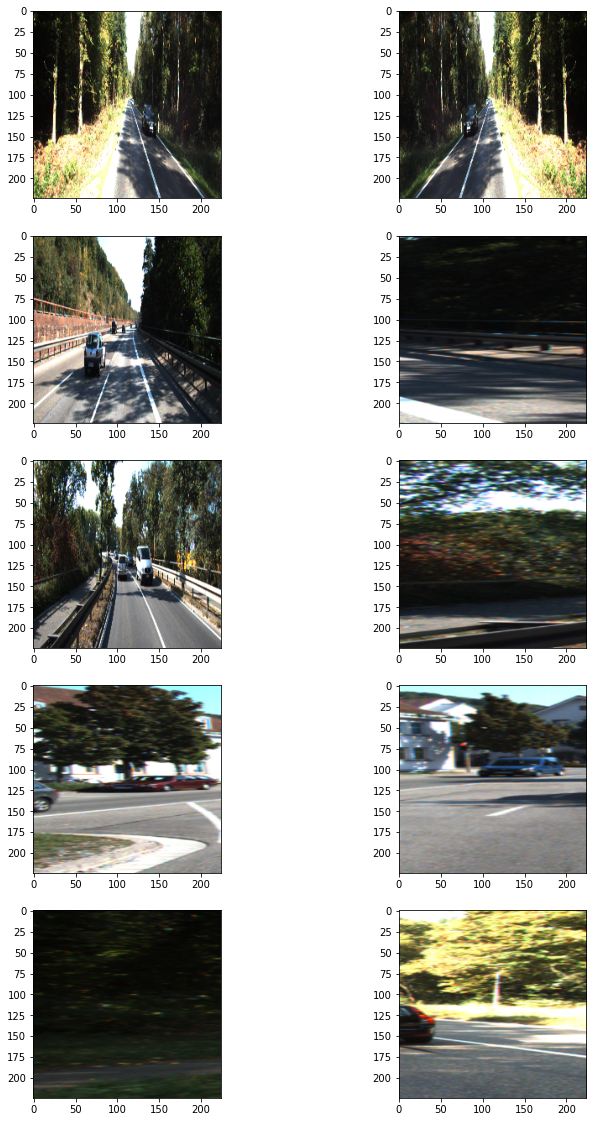

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):

 def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):

    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()
 def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
 def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

 def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

 def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False) #only resize
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# 2. U - Net 모델 구현하기

![image](https://user-images.githubusercontent.com/86637320/138801812-f5e32cb3-5e20-4a39-8196-09b4d75ed4a6.png)

In [6]:
def get_crop_layer(target, refer):
    
    target_shape = int_shape(target)
    refer_shape = int_shape(refer)
    # width, the 3rd dimension
    cw = target_shape[2] - refer_shape[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target_shape[1] - refer_shape[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)
    
    crop = Cropping2D(cropping=((ch1,ch2),(cw1,cw2)))(target)

    return crop

Generator를 변경하면 zero-padding(same)이 없어도 된다. 하지만 224 x 224 image의 경우 zero-padding을 하지 않으면 출력이 36 x 36으로 줄어들기 때문에 논문에서처럼 (572x572) 좀 더 큰 이미지 입력을 사용할 때 시도해보면 좋을 것이다.

In [7]:
def build_origin_model(input_shape=(572,572,3)):
    
    inputs = Input(input_shape)
    
    #contracting 
    conv1 = Conv2D(64, 3,  activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3,  activation = 'relu', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    conv3 = Conv2D(256, 3,  activation = 'relu', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    conv4 = Conv2D(512, 3,  activation = 'relu', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    conv5 = Conv2D(1024, 3,  activation = 'relu', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv5)
    
    #expanding
    up1 = Conv2DTranspose(512, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv5) #strides 지정 필요!
    crop1 = get_crop_layer(conv4,up1)
    concat1 = concatenate([crop1, up1], axis = 3)
    conv6 = Conv2D(512, 3,  activation = 'relu', kernel_initializer = 'he_normal')(concat1)
    conv6 = Conv2D(512, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv6)
    
    up2 = Conv2DTranspose(256, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv6)
    crop2 = get_crop_layer(conv3,up2)
    concat2= concatenate([crop2, up2], axis = 3)
    conv7 = Conv2D(256, 3,  activation = 'relu', kernel_initializer = 'he_normal')(concat2)
    conv7 = Conv2D(256, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv7)
    
    up3 = Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv7)
    crop3 = get_crop_layer(conv2,up3)
    concat3= concatenate([crop3, up3], axis = 3)
    conv8 = Conv2D(128, 3,  activation = 'relu', kernel_initializer = 'he_normal')(concat3)
    conv8 = Conv2D(128, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv8)
    
    up4 = Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv8)
    crop4 = get_crop_layer(conv1,up4)
    concat4= concatenate([crop4, up4], axis = 3)
    conv9 = Conv2D(64, 3,  activation = 'relu', kernel_initializer = 'he_normal')(concat4)
    conv9 = Conv2D(64, 3,  activation = 'relu', kernel_initializer = 'he_normal')(conv9)
    outputs = Conv2D(1, 1, activation = 'sigmoid', kernel_initializer = 'he_normal')(conv9) #0~1로 조정
    
    model = Model(inputs = inputs, outputs = outputs)
     
    return model

In [8]:
origin_model = build_origin_model()
origin_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 572, 572, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 284, 284, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
def build_model(input_shape=(224,224,3)):
    
    inputs = Input(input_shape)
    
    #contracting 
    conv1 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    conv3 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    conv4 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    conv5 = Conv2D(1024, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv5)
    
    #expanding
    up1 = Conv2DTranspose(512, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv5) #strides 지정 필요!
    crop1 = get_crop_layer(conv4,up1)
    concat1 = concatenate([crop1, up1], axis = 3)
    conv6 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(concat1)
    conv6 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv6)
    
    up2 = Conv2DTranspose(256, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv6)
    crop2 = get_crop_layer(conv3,up2)
    concat2= concatenate([crop2, up2], axis = 3)
    conv7 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(concat2)
    conv7 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv7)
    
    up3 = Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv7)
    crop3 = get_crop_layer(conv2,up3)
    concat3= concatenate([crop3, up3], axis = 3)
    conv8 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(concat3)
    conv8 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv8)
    
    up4 = Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', kernel_initializer = 'he_normal')(conv8)
    crop4 = get_crop_layer(conv1,up4)
    concat4= concatenate([crop4, up4], axis = 3)
    conv9 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(concat4)
    conv9 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv9)
    outputs = Conv2D(1, 1, activation = 'sigmoid', kernel_initializer = 'he_normal')(conv9) # 0~1로 조정
    
    model = Model(inputs = inputs, outputs = outputs)
     
    return model

In [10]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [14]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit(
     x = train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     verbose = 1
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 15s 1s/step - loss: 0.1821 - val_loss: 0.1449
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.1105 - val_loss: 0.0741
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.0547 - val_loss: 0.0537
Epoch 4/100
11/11 [==============================] - 13s 1s/step - loss: 0.0423 - val_loss: 0.0460
Epoch 5/100
11/11 [==============================] - 13s 1s/step - loss: 0.0275 - val_loss: 0.0458
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.0293 - val_loss: 0.0438
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.0335 - val_loss: 0.0429
Epoch 8/100
11/11 [==============================] - 13s 1s/step - loss: 0.0303 - val_loss: 0.0422
Epoch 9/100
11/11 [==============================] - 13s 1s/step - loss: 0.0347 - val_loss: 0.0422
Epoch 10/100
11/11 [==============================] - 13s 1s/step - loss: 0.0258 - val_loss: 0.0407
Epoch 11/

#### 모델 시각화

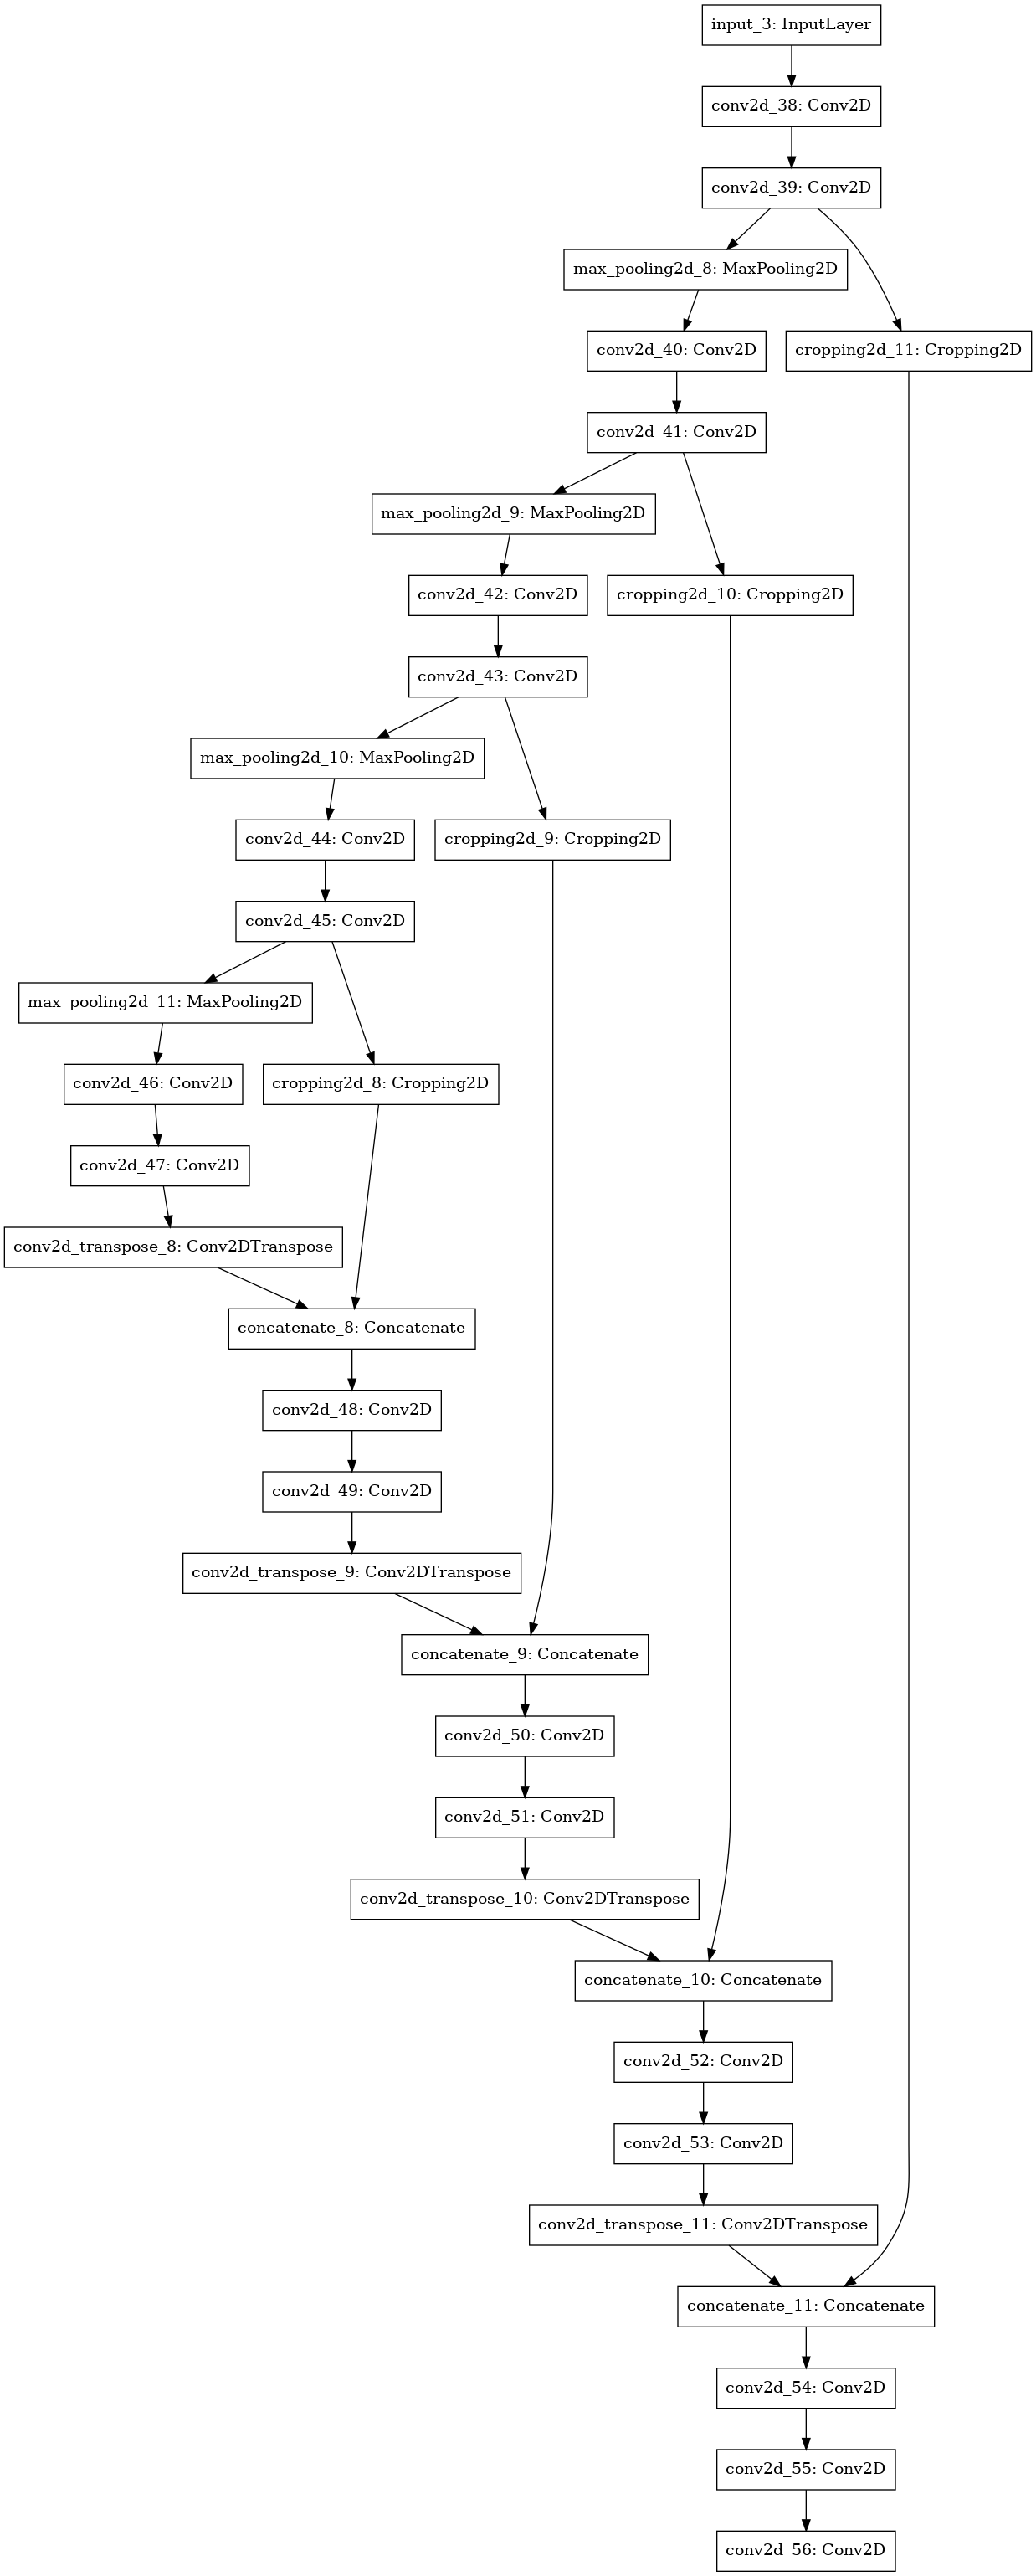

In [31]:
plot_model(model, to_file='model.png')

___

## 3. 결과 확인하기

In [11]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
loaded_model = tf.keras.models.load_model(model_path)

원본 이미지에 overlay 하기!

#### 원본 이미지

![image](https://user-images.githubusercontent.com/86637320/138895958-19b91dae-5c09-47ca-b16c-18c39ec2dd69.png)

In [43]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

#### 도로 영역이 하얗게 변한 것을 알 수 있다.

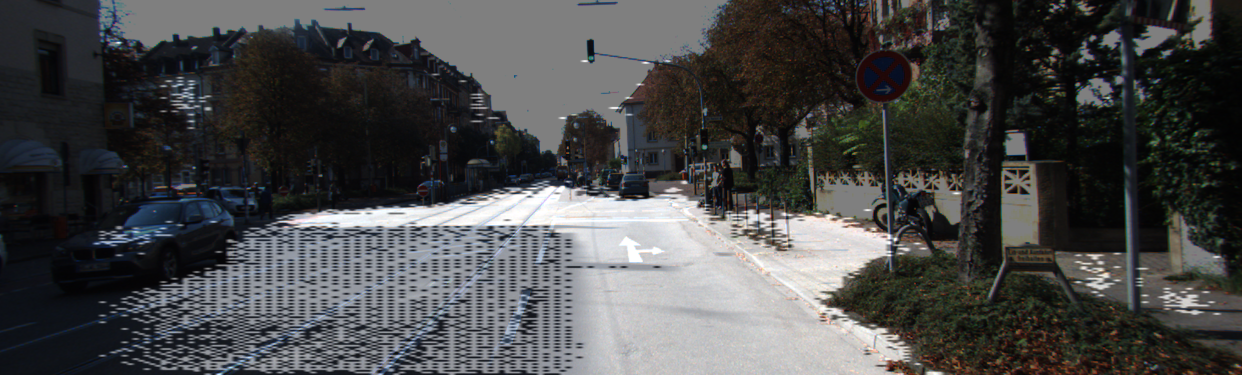

In [44]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     loaded_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

#### IoU 확인하기

In [60]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [61]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    display(output)   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

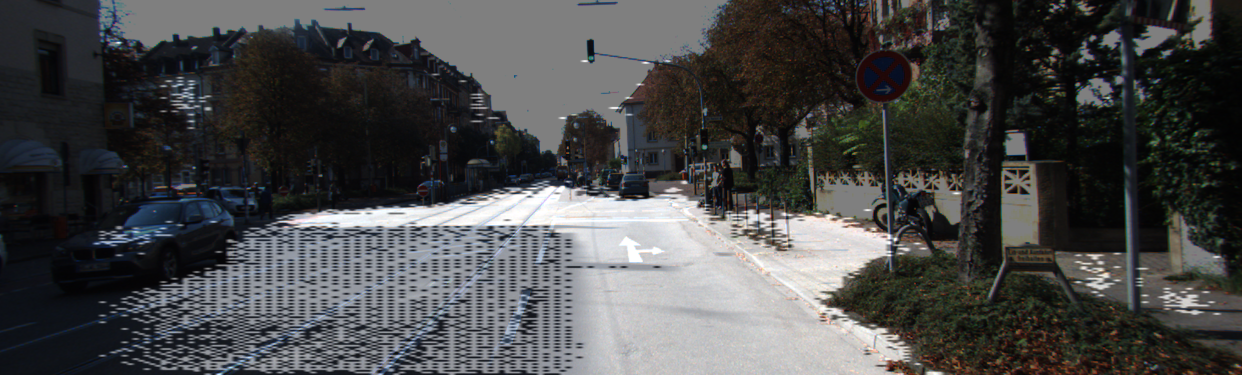

IoU : 0.617629


0.6176285414480588

In [16]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     loaded_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
calculate_iou_score(target, prediction)

___

## 4. U - Net ++

![image](https://user-images.githubusercontent.com/86637320/138987338-d64ba0a6-cf98-47e1-a6a6-34ace211dfb4.png)

![image](https://user-images.githubusercontent.com/86637320/138987772-2e453611-e8db-4fff-8af7-6b559bcd0404.png)

U-net에 DenseNet 구조를 적용한 모델

#### 실제로는 Backbone 네트워크를 연결해야 하지만 연결됐다고 가정하고 상위 부분만 구현한다.

In [49]:
def build_nested_model(input_shape=(224,224,3), deep_supervision=True, batch_size = 4):
    
    inputs = Input(input_shape)
    
    #Backbone
    conv0_0 = Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    conv0_0 = Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    
    conv1_0 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool0_0)
    conv1_0 = Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    
    conv2_0 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool1_0)
    conv2_0 = Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    
    conv3_0 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool2_0)
    conv3_0 = Conv2D(256, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    
    conv4_0 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(pool3_0)
    conv4_0 = Conv2D(512, 3, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv4_0)
    pool4_0 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    
    #대각 layer    
    # 첫번째   
    # X0,1
    up1_0 = Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv1_0)
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3)
    conv0_1 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1)
    
    # X1,1
    up2_0 = Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv2_0)
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    
    # X2,1
    up3_0 = Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv3_0)
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    
    # X3,1
    up4_0 = Conv2DTranspose(256, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv4_0)
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)  
    
    #두번째
    # X0,2
    up1_1 = Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv1_1)
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis = 3)
    conv0_2 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2)
    
    # X1,2
    up2_1 = Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv2_1)
    merge1_2 = concatenate([up2_1, conv1_0, conv1_0], axis = 3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
    
    # X2,2
    up3_1 = Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv3_1)
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)
    
    #세번째
    # X0,3
    up1_2 = Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', kernel_initializer ='he_normal')(conv1_2)
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3)
    # X1,3
    up2_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    #네번째
    # X0,4
    up1_3 = Conv2D(32, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_3)) 
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis = 3)
    conv0_4 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_4)

    #deep_supervision
    output1 = Conv2D(1, 1, activation='sigmoid', name = 'output1')(conv0_1)
    output2 = Conv2D(1, 1, activation='sigmoid', name = 'output2')(conv0_2)
    output3 = Conv2D(1, 1, activation='sigmoid', name = 'output3')(conv0_3)
    output4 = Conv2D(1, 1, activation='sigmoid', name = 'output4')(conv0_4)
    
    if deep_supervision:
        model = Model(inputs=inputs, outputs=[output1,
                                               output2,
                                               output3,
                                               output4])
    else:
        model = Model(inputs = inputs, outputs=output4)

    return model

#### deep_supervision 사용 시 Loss를 새로 지정해줘야 한다.

![image](https://user-images.githubusercontent.com/86637320/139002288-d4d85305-42dd-4f82-8aa7-96dfd395dcbd.png)

Yb : flatten preditcted probabilities,Y^b : flatten ground truth, N : batch-size

In [52]:
unet_pp_ds = build_nested_model(deep_supervision=True)
unet_pp_ds.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_174 (Conv2D)             (None, 224, 224, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, 224, 224, 32) 9248        conv2d_174[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 112, 112, 32) 0           conv2d_175[0][0]                 
____________________________________________________________________________________________

In [53]:
unet_pp = build_nested_model(deep_supervision=False)
unet_pp.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 224, 224, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 224, 224, 32) 9248        conv2d_206[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D) (None, 112, 112, 32) 0           conv2d_207[0][0]                 
____________________________________________________________________________________________

#### deep_supervision을 사용하지 않은 모델의 성능을 확인한다.

In [54]:
unet_pp.compile(optimizer = Adam(lr = 3e-4), loss = 'binary_crossentropy')
unet_pp.fit(
     x=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Epoch 1/100
11/11 [==============================] - 56s 1s/step - loss: 0.6420 - val_loss: 0.0997
Epoch 2/100
11/11 [==============================] - 14s 1s/step - loss: 0.0372 - val_loss: 0.0910
Epoch 3/100
11/11 [==============================] - 14s 1s/step - loss: 0.0509 - val_loss: 0.0300
Epoch 4/100
11/11 [==============================] - 14s 1s/step - loss: 0.0360 - val_loss: 0.0270
Epoch 5/100
11/11 [==============================] - 14s 1s/step - loss: 0.0306 - val_loss: 0.0260
Epoch 6/100
11/11 [==============================] - 14s 1s/step - loss: 0.0232 - val_loss: 0.0306
Epoch 7/100
11/11 [==============================] - 15s 1s/step - loss: 0.0296 - val_loss: 0.0273
Epoch 8/100
11/11 [==============================] - 15s 1s/step - loss: 0.0308 - val_loss: 0.0236
Epoch 9/100
11/11 [==============================] - 15s 1s/step - loss: 0.0244 - val_loss: 0.0248
Epoch 10/100
11/11 [==============================] - 15s 1s/step - loss: 0.0253 - val_loss: 0.0219
Epoch 11/

OSError: Unable to create file (unable to open file: name = '/aiffel/aiffel/semantic_segmentation/data/training/seg_model_unet_pp.h5', errno = 30, error message = 'Read-only file system', flags = 13, o_flags = 242)

In [57]:
unet_pp_path = '/seg_model_unet_pp.h5'
unet_pp.save(unet_pp_path)

In [58]:
unet_pp = tf.keras.models.load_model(unet_pp_path)

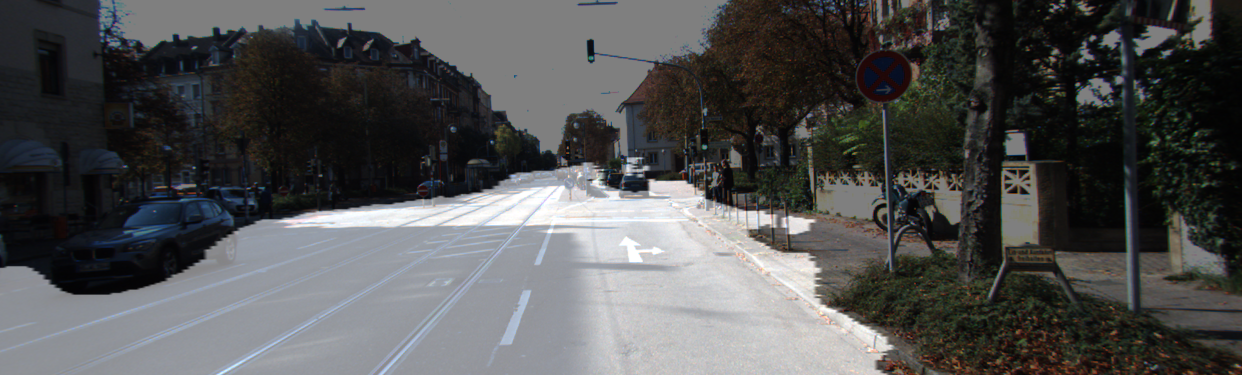

IoU : 0.891913


0.8919130187606594

In [62]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
calculate_iou_score(target, prediction)

#### 모델 별 IoU 비교하기

In [63]:
def calculate_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    return iou_score

#### 사진이 많으면 깃허브에서 안보여서 display 삭제

In [69]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

#### U - Net과 U - Net++의 Segmentation 결과

- 25개의 이미지 활용

In [70]:
unet_iou = []
unet_pp_iou = []

for i in range(25):  # 이미지 25개로 테스트
    # U-Net의 IoU 계산
    output, prediction, target = get_output(
         loaded_model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_iou.append(calculate_iou(target, prediction))

    # U-Net++의 IoU 계산
    output, prediction, target = get_output(
         unet_pp, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_pp_iou.append(calculate_iou(target, prediction))

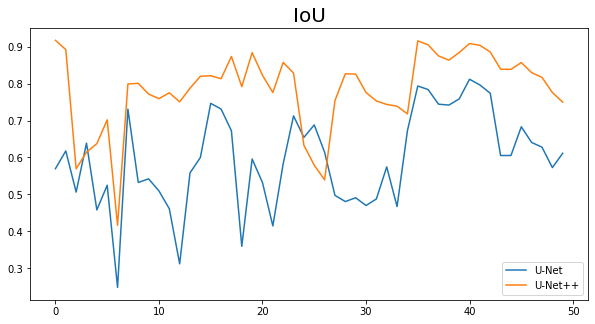

In [67]:
plt.figure(figsize=(10,5))
plt.plot(unet_iou)
plt.plot(unet_pp_iou)
plt.title('IoU', fontsize=20)
plt.legend(['U-Net', 'U-Net++'])
plt.show()

# 결론

예상대로 U - Net++가 U - Net 보다 좋은 IoU 결과를 얻었다. U - Net을 구현하면서 처음으로 Layer의 일부를 잘라내는 Cropping2D 사용해봤다. keras document의 설명으론 잘 이해가 되지 않아서 [github](https://github.com/zizhaozhang/unet-tensorflow-keras/blob/master/model.py)에 있는 코드를 보면서 이해하려고 노력했다. U - Net++을 구현할 때는 논문에서 처럼 output을 4개를 만들어(Deep supervision)이를 통해 Loss를 새로 구현해 학습에 활용해야 하지만 우선 1개의 출력만을 가지고 성능을 비교했다. Custom loss에 대해서 좀 더 알아본 후 다시 구현해보겠다.

- U-net++의 파라미터 수가 U-net과 비교했을 때 3분의 1 수준인데 성능은 더 좋은 걸로 보아 U-net에 DenseNet 개념을 적용한 것은 매우 좋은 시도였음을 알 수 있다.